In [24]:
%pip install plotly

^C
Note: you may need to restart the kernel to use updated packages.


   ---------------------------------------- 0.0/19.1 MB ? eta -:--:--
   -------- ------------------------------- 4.2/19.1 MB 22.9 MB/s eta 0:00:01
   ---------------------- ----------------- 10.7/19.1 MB 25.8 MB/s eta 0:00:01
   ----------------------------------- ---- 17.0/19.1 MB 27.5 MB/s eta 0:00:01
   ---------------------------------------- 19.1/19.1 MB 25.6 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from math import ceil
from scipy.stats import zscore
import plotly.express as px


In [2]:
df = pd.read_csv('Electric_Vehicles.csv')

In [3]:
#Optimising memory by appling correct data types to features
df = df.astype({
    'User ID': 'str',
    'Vehicle Model': 'category',
    'Charging Station ID': 'str',
    'Charging Station Location': 'category',
    'Charging Start Time': 'datetime64[ns]',
    'Charging End Time': 'datetime64[ns]',
    'Time of Day': 'category',
    'Day of Week': 'category',
    'Charger Type': 'category',
    'User Type': 'category'
})

print(df.dtypes)


#Replace missing values with median
df[['Energy Consumed (kWh)', 'Charging Rate (kW)', 'Distance Driven (since last charge) (km)']] = df[['Energy Consumed (kWh)', 'Charging Rate (kW)', 'Distance Driven (since last charge) (km)']].fillna(df[['Energy Consumed (kWh)', 'Charging Rate (kW)', 'Distance Driven (since last charge) (km)']].median())

df.isnull().sum()

User ID                                             object
Vehicle Model                                     category
Battery Capacity (kWh)                             float64
Charging Station ID                                 object
Charging Station Location                         category
Charging Start Time                         datetime64[ns]
Charging End Time                           datetime64[ns]
Energy Consumed (kWh)                              float64
Charging Duration (hours)                          float64
Charging Rate (kW)                                 float64
Charging Cost (USD)                                float64
Time of Day                                       category
Day of Week                                       category
State of Charge (Start %)                          float64
State of Charge (End %)                            float64
Distance Driven (since last charge) (km)           float64
Temperature (°C)                                   float

User ID                                     0
Vehicle Model                               0
Battery Capacity (kWh)                      0
Charging Station ID                         0
Charging Station Location                   0
Charging Start Time                         0
Charging End Time                           0
Energy Consumed (kWh)                       0
Charging Duration (hours)                   0
Charging Rate (kW)                          0
Charging Cost (USD)                         0
Time of Day                                 0
Day of Week                                 0
State of Charge (Start %)                   0
State of Charge (End %)                     0
Distance Driven (since last charge) (km)    0
Temperature (°C)                            0
Vehicle Age (years)                         0
Charger Type                                0
User Type                                   0
dtype: int64

## Checking for logical inconsistencies

In [4]:
inconsistent_charge = df[df['State of Charge (Start %)'] > df['State of Charge (End %)']]
print("Inconsistent charges: ", len(inconsistent_charge))


print("\nInconsistent stations:")
inconsistent_stations = df.groupby('Charging Station ID')['Charging Station Location'].nunique()
inconsistent_stations = inconsistent_stations[inconsistent_stations > 1]
print(inconsistent_stations.head(100))  


# Check for negative values
print("\n\nRows with Negative Energy Consumed:")
print(df[df['Energy Consumed (kWh)'] < 0])

print("\n\nRows with Negative Distance Driven:")
print(df[df['Distance Driven (since last charge) (km)'] < 0])

Inconsistent charges:  268

Inconsistent stations:
Charging Station ID
Station_1      3
Station_10     4
Station_100    2
Station_101    3
Station_103    4
              ..
Station_213    2
Station_214    3
Station_215    2
Station_216    4
Station_217    2
Name: Charging Station Location, Length: 100, dtype: int64


Rows with Negative Energy Consumed:
Empty DataFrame
Columns: [User ID, Vehicle Model, Battery Capacity (kWh), Charging Station ID, Charging Station Location, Charging Start Time, Charging End Time, Energy Consumed (kWh), Charging Duration (hours), Charging Rate (kW), Charging Cost (USD), Time of Day, Day of Week, State of Charge (Start %), State of Charge (End %), Distance Driven (since last charge) (km), Temperature (°C), Vehicle Age (years), Charger Type, User Type]
Index: []


Rows with Negative Distance Driven:
Empty DataFrame
Columns: [User ID, Vehicle Model, Battery Capacity (kWh), Charging Station ID, Charging Station Location, Charging Start Time, Charging End Time

## One-hot encoding categorical data

In [5]:
df = pd.get_dummies(df, columns=['Vehicle Model', 'Charging Station Location', 'Time of Day', 'Day of Week', 'Charger Type', 'User Type'], drop_first=True)

# Convert only one-hot encoded columns to integers
df = df.apply(lambda x: x.astype(int) if x.dtype == 'bool' else x)

In [6]:
print(df.dtypes)

User ID                                             object
Battery Capacity (kWh)                             float64
Charging Station ID                                 object
Charging Start Time                         datetime64[ns]
Charging End Time                           datetime64[ns]
Energy Consumed (kWh)                              float64
Charging Duration (hours)                          float64
Charging Rate (kW)                                 float64
Charging Cost (USD)                                float64
State of Charge (Start %)                          float64
State of Charge (End %)                            float64
Distance Driven (since last charge) (km)           float64
Temperature (°C)                                   float64
Vehicle Age (years)                                float64
Vehicle Model_Chevy Bolt                             int64
Vehicle Model_Hyundai Kona                           int64
Vehicle Model_Nissan Leaf                            int

In [7]:
df.shape

(1320, 35)

## Feature Engineering

In [13]:
df.columns

Index(['User ID', 'Battery Capacity (kWh)', 'Charging Station ID',
       'Charging Start Time', 'Charging End Time', 'Energy Consumed (kWh)',
       'Charging Duration (hours)', 'Charging Rate (kW)',
       'Charging Cost (USD)', 'State of Charge (Start %)',
       'State of Charge (End %)', 'Distance Driven (since last charge) (km)',
       'Temperature (°C)', 'Vehicle Age (years)', 'Vehicle Model_Chevy Bolt',
       'Vehicle Model_Hyundai Kona', 'Vehicle Model_Nissan Leaf',
       'Vehicle Model_Tesla Model 3', 'Charging Station Location_Houston',
       'Charging Station Location_Los Angeles',
       'Charging Station Location_New York',
       'Charging Station Location_San Francisco', 'Time of Day_Evening',
       'Time of Day_Morning', 'Time of Day_Night', 'Day of Week_Monday',
       'Day of Week_Saturday', 'Day of Week_Sunday', 'Day of Week_Thursday',
       'Day of Week_Tuesday', 'Day of Week_Wednesday', 'Charger Type_Level 1',
       'Charger Type_Level 2', 'User Type_Commut

In [18]:
#charging speed (not! charging rate cwhich can fluctuate throughout whole session. this is more holistic metric)
df['Charging Speed (kW/h)'] = df['Energy Consumed (kWh)'] / df['Charging Duration (hours)']
#charge difference
df['Charge Difference (%)'] = df['Energy Consumed (kWh)'] / df['Charging Duration (hours)']
#charge efficiency
df['Charging Efficiency'] = df['Energy Consumed (kWh)'] / df['Charge Difference (%)']
df['Charging Rate Efficiency'] = df['Energy Consumed (kWh)'] / df['Charging Duration (hours)']


#time of day adjustments
df['Charging Start Hour'] = df['Charging Start Time'].dt.hour # Extract hour from Charging Start Time

#impact of temperature on charging rate
df['Temperature-Adjusted Charging Rate'] = df['Temperature (°C)'] * df['Charging Rate (kW)']


df['Average Charging Duration'] = df.groupby('User ID')['Charging Duration (hours)'].transform('mean')
df['Average Energy Consumed'] = df.groupby('User ID')['Energy Consumed (kWh)'].transform('mean')


df['Peak vs Off-Peak Efficiency'] = df.groupby('Time of Day Category')['Charging Rate Efficiency'].transform('mean')

df['Station Usage Intensity'] = df.groupby('Charging Station ID')['Charging Duration (hours)'].transform('sum')

df['Vehicle Age Impact'] = df['Vehicle Age (years)'] * df['Charging Duration (hours)']

df['Battery Degradation Impact'] = df['Vehicle Age (years)'] * df['Energy Consumed (kWh)']


# ------------------------------------------------------------------------------------------------

# Define time-of-day categories based on common peak hours
def time_of_day_category(hour):
    if 7 <= hour <= 9 or 17 <= hour <= 19:
        return 'Peak'
    else:
        return 'Off-Peak'

df['Time of Day Category'] = df['Charging Start Hour'].apply(time_of_day_category) 


# # -------------------------------------------------------------------------------------------------

# # Calculate the mean charging duration per location using the one-hot encoded columns
# location_mean = df.groupby(['Charging Station Location_Houston', 'Charging Station Location_Los Angeles',
#                             'Charging Station Location_New York', 'Charging Station Location_San Francisco'])['Charging Duration (hours)'].mean().reset_index()

# # Merge back to the original DataFrame
# df = df.merge(location_mean, how='left', left_on='Charging Station Location', right_on='Charging Station Location')



# # --------------------------------------------------------------------------------------------------

# # Calculate the Charger Location Saturation for each location using one-hot encoded columns
# df['Charger Location Saturation'] = (
#     df.groupby(['Charging Station Location_Houston', 'Charging Station Location_Los Angeles',
#                 'Charging Station Location_New York', 'Charging Station Location_San Francisco'])['Charging Station ID']
#     .transform('count') 
#     / 
#     df.groupby(['Charging Station Location_Chicago', 'Charging Station Location_Houston', 
#                 'Charging Station Location_Los Angeles', 'Charging Station Location_New York',
#                 'Charging Station Location_San Francisco'])['Energy Consumed (kWh)']
#     .transform('sum')
# )


In [ ]:
df.columns

## Feature selection

In [19]:
print(df.dtypes)

User ID                                             object
Battery Capacity (kWh)                             float64
Charging Station ID                                 object
Charging Start Time                         datetime64[ns]
Charging End Time                           datetime64[ns]
Energy Consumed (kWh)                              float64
Charging Duration (hours)                          float64
Charging Rate (kW)                                 float64
Charging Cost (USD)                                float64
State of Charge (Start %)                          float64
State of Charge (End %)                            float64
Distance Driven (since last charge) (km)           float64
Temperature (°C)                                   float64
Vehicle Age (years)                                float64
Vehicle Model_Chevy Bolt                             int64
Vehicle Model_Hyundai Kona                           int64
Vehicle Model_Nissan Leaf                            int

                                          Battery Capacity (kWh)  \
Battery Capacity (kWh)                                  1.000000   
Charging Start Time                                     0.004881   
Charging End Time                                       0.004983   
Energy Consumed (kWh)                                   0.000328   
Charging Duration (hours)                              -0.024824   
Charging Rate (kW)                                      0.015691   
Charging Cost (USD)                                    -0.000492   
State of Charge (Start %)                              -0.072148   
State of Charge (End %)                                -0.011512   
Distance Driven (since last charge) (km)               -0.040130   
Temperature (°C)                                       -0.036411   
Vehicle Age (years)                                     0.037673   
Vehicle Model_Chevy Bolt                               -0.014965   
Vehicle Model_Hyundai Kona                      

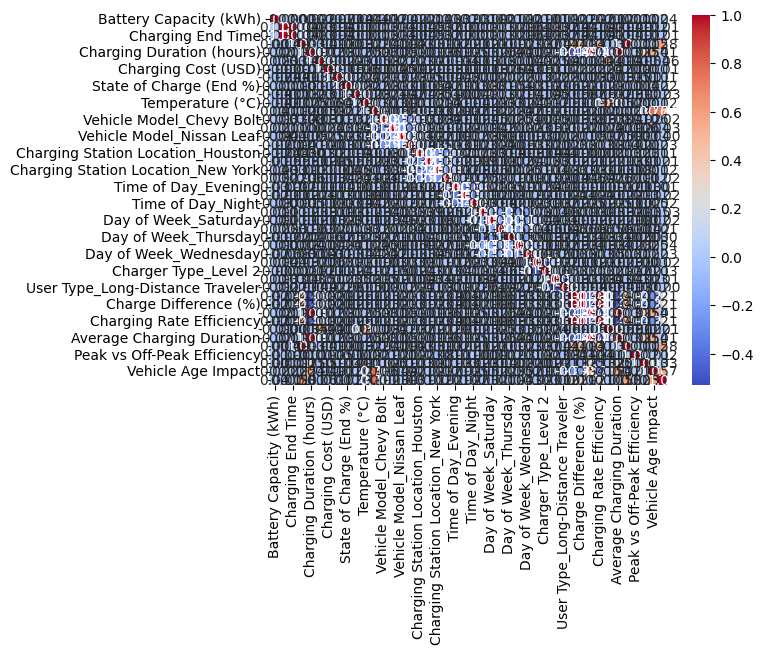

In [22]:
# Filter out non-numeric columns for correlation analysis
numeric_df = df.select_dtypes(include=['float64', 'int64', 'datetime64[ns]'])

# Calculate the correlation matrix on the numeric data
correlation_matrix = numeric_df.corr()

# Print the correlation matrix
print(correlation_matrix)

# Visualize the correlation matrix
import seaborn as sns
import matplotlib.pyplot as plt
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.show()


In [ ]:

# Create an interactive heatmap using Plotly
fig = px.imshow(correlation_matrix, text_auto=True, color_continuous_scale='Viridis')
fig.update_layout(width=1000, height=1000)
fig.show()


ModuleNotFoundError: No module named 'plotly'